In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
import sys
import random
from tqdm import tqdm


import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

from PIL import Image
from skimage.io import imread, imshow, imread_collection, concatenate_images

from keras.preprocessing.image import ImageDataGenerator
from skimage.transform import resize
from skimage.color import rgb2gray, gray2rgb, rgb2lab, lab2rgb


In [3]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
INPUT_SHAPE=(IMG_HEIGHT, IMG_WIDTH, 1)
TRAIN_PATH = '../input/landscape-pictures/'

TRAIN_id = next(os.walk(TRAIN_PATH))[2]



In [4]:
len(TRAIN_id)

4319

In [5]:
def input_data(IMG_HEIGHT, IMG_WIDTH,train_ids,TRAIN_PATH):
    missing_count = 0
    print('Getting train images ... ')
    sys.stdout.flush()
    x=[]
    for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
        path = TRAIN_PATH + id_+''
        try:
            img = imread(path)
            img = resize(img, (IMG_HEIGHT, IMG_WIDTH,3), mode='constant', preserve_range=False)
            x.append(img)
        except:
            missing_count += 1
    x=((np.array(x)).astype('float32'))
    print(x.shape)
    print("Total missing: "+ str(missing_count))
    return x

X_train = input_data(IMG_HEIGHT, IMG_WIDTH,TRAIN_id[:3000],TRAIN_PATH)

Getting train images ... 


100%|██████████| 3000/3000 [05:42<00:00,  8.75it/s]


(3000, 256, 256, 3)
Total missing: 0


(3000, 256, 256, 3)


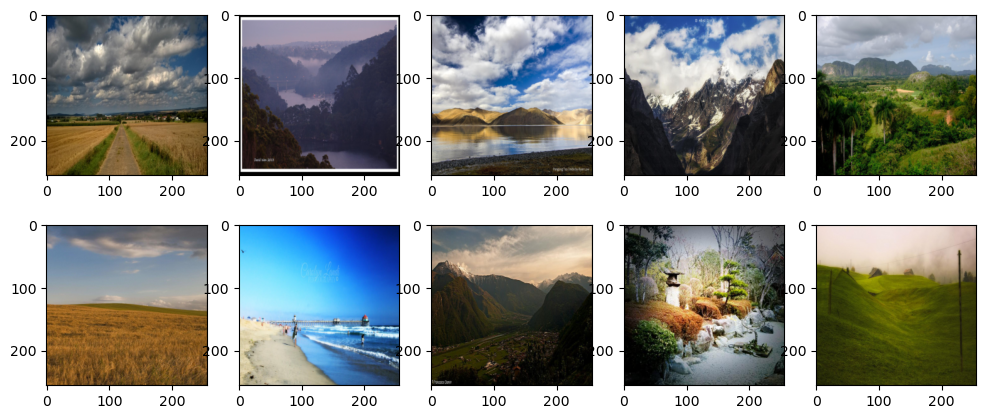

In [6]:
print(X_train.shape)
fig = plt.figure(figsize=(12, 5))

for i,j in zip(list(range(0,10)), list(range(1,11)) ):
    ax = fig.add_subplot(2,5,j)
    ax.imshow(X_train[j])

plt.show()

In [7]:

def generate_image(dataset, batch_size):
    datagen = ImageDataGenerator(shear_range=0.2,zoom_range=0.2,
                                 rotation_range=20,horizontal_flip=True) 
    data_gen = datagen.flow(dataset, batch_size=batch_size) 
    print(len(data_gen))
    X = []
    Y = []
    for i in tqdm(range(len(data_gen))):
        for img in data_gen[i]:
            lab = rgb2lab(img)
            X.append(lab[:,:,0])
            Y.append(lab[:,:,1:]/128) ## normalize it
    X = np.array(X)
    Y = np.array(Y)
    X = X.reshape(X.shape+(1,))  # X and Y have the same dimension
    print("input L image shape  : ",X.shape)
    print("input AB image shape : ",Y.shape)
    return X, Y



In [8]:
 X_batch , Y_batch = generate_image(dataset=X_train[:], batch_size = 10)

300


100%|██████████| 300/300 [01:07<00:00,  4.46it/s]


input L image shape  :  (3000, 256, 256, 1)
input AB image shape :  (3000, 256, 256, 2)


(3000, 256, 256, 1)


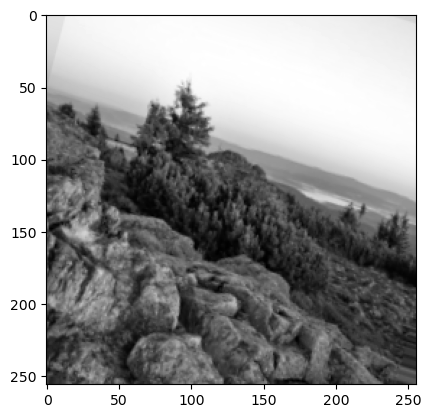

In [9]:
plt.imshow(X_batch[2][:,:,0],cmap="gray")
print(X_batch.shape)

##  Model Subclass for Convlution NN  

In [10]:
from tensorflow.keras.layers import Input, Conv2D, ReLU, BatchNormalization, \
    Flatten, Dense
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf

In [11]:
# CNN + BN + ReLu 

class CNNblock(tf.keras.layers.Layer):
    def __init__(self,filter,kernelsize,stride,dilation_rate=1):
        super(CNNblock, self).__init__()
        self.filter=filter,
        self.kernelsize=kernelsize,
        self.stride=stride,
        self.dilation_rate=dilation_rate
        self.conv= tf.keras.layers.Conv2D(filters=filter, kernel_size=kernelsize, strides=stride, dilation_rate=dilation_rate, padding='SAME')
        self.bn =tf.keras.layers.BatchNormalization() 
        
    def call(self,input_data,training=False):
        x=self.conv(input_data)
#         x=self.bn(x,training=training)
        x=tf.nn.relu(x)      
        return x    
       
model=keras.Sequential([
    CNNblock(16,3,1),
    CNNblock(16,3,2),
    CNNblock(32,3,1),
    CNNblock(32,3,2),
    CNNblock(64,3,1),
    CNNblock(64,3,1),
    CNNblock(64,3,2),
    CNNblock(128,3,1),
    CNNblock(128,3,1),
    CNNblock(128,3,1),
    CNNblock(128,3,1,dilation_rate=2),
    CNNblock(128,3,1,dilation_rate=2),
    CNNblock(128,3,1,dilation_rate=2),
    CNNblock(128,3,1,dilation_rate=2),
    CNNblock(128,3,1,dilation_rate=2),
    CNNblock(128,3,1,dilation_rate=2),
    CNNblock(128,3,1),
    CNNblock(128,3,1),
    CNNblock(128,3,1),
])

# add block 8th
model.add(keras.layers.UpSampling2D(size=(4, 4)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=1))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=1))

# add two color channels (A, B)
model.add(Conv2D(121, (1, 1), activation='softmax', padding='valid', strides=1))
model.add(Conv2D(2, (1, 1), padding='valid', strides=1, dilation_rate=1))
model.add(keras.layers.UpSampling2D(size=(2, 2)))



In [12]:
X_batch.shape

(3000, 256, 256, 1)

In [13]:
# '''
# model(X_batch)
# model.summary()

# optimizer = keras.optimizers.Adam(learning_rate=.00001)
# loss_fn = tf.keras.losses.MeanSquaredError()
# train_acc_metric= tf.keras.metrics.RootMeanSquaredError()

# @tf.function
# def train_step(x, y):
#     with tf.GradientTape() as tape:
#         logits = model(x, training=True)
#         loss_value = loss_fn(y, logits)
#     grads = tape.gradient(loss_value, model.trainable_weights)
#     optimizer.apply_gradients(zip(grads, model.trainable_weights))
#     train_acc_metric.update_state(y, logits)
#     return loss_value

# batch_size=50

# # Prepare the training dataset.
# train_dataset = tf.data.Dataset.from_tensor_slices((X_batch, Y_batch))
# train_dataset = train_dataset.shuffle(buffer_size=X_batch.shape[0]).batch(batch_size)

# epochs = 100

# for epoch in range(epochs):
#     print("Epoch %d/%d" % (epoch,epochs))
#     for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
#         loss_value = train_step(x_batch_train, y_batch_train)

#         # Log every 200 batches.
#         if step % 50 == 0:
#             print("Training loss: %.4f"% (float(loss_value)))
        
#     train_acc = train_acc_metric.result()
#     print("Training acc over epoch: %.4f" % (float(train_acc),))

#     train_acc_metric.reset_states()
            
# '''


In [14]:

# from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# # Set a learning rate annealer
# learning_rate_reduction = ReduceLROnPlateau(monitor='loss', 
#                                             patience=5, 
#                                             verbose=1, 
#                                             factor=0.5,
#                                             min_lr=0.1)
# filepath = "mycnn_Model.h5"
# checkpoint = ModelCheckpoint(filepath,
#                              save_best_only=True,
#                              monitor='loss',
#                              mode='min')

# model_callbacks = [learning_rate_reduction,checkpoint]

In [ ]:
# model(X_batch)
optimizer = keras.optimizers.Adam(learning_rate=.001)
model.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])
# model.summary()


callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
# model_history = model.fit(X_batch, Y_batch, validation_split=0.2, epochs=500, batch_size=50,callbacks=callback)

model_history = model.fit(X_batch, Y_batch, validation_split=0.2, epochs=200, batch_size=50)


Epoch 1/200
48/48 [==============================] - ETA: 0s - loss: 0.0167 - accuracy: 0.5206

In [ ]:
l=5
s=45

model_output = model.predict(X_batch[s:s+l])
model_output.shape

In [ ]:
# plt.rcParams["font.family"] = "monospace"
# plt.rcParams["font.monospace"] = ["FreeMono"]
def plot_colored_images(X, Y, Z,IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH= IMG_WIDTH):
    results = []
    reference = []
    for i in range(len(X)):
        result, ref = np.zeros((IMG_HEIGHT, IMG_WIDTH, 3)), np.zeros((IMG_HEIGHT, IMG_WIDTH, 3))
        layer1 = Z[i][:,:,0] * 128  # color channels
        layer2 = Z[i][:,:,1] * 128
        result[:,:,0] = X[i][:,:,0]  # black-white channel
        result[:,:,1] = layer1
        result[:,:,2] = layer2
        ref[:,:,0] = X[i][:,:,0]
        ref[:,:,1] = Y[i][:,:,0] * 128
        ref[:,:,2] = Y[i][:,:,1] * 128
        results.append(lab2rgb(result))
        reference.append(lab2rgb(ref))
    results = np.array(results)
    reference = np.array(reference)
    ncols=5
    nrows=3
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 8))

    for i in range(len(X)):
        for j in range(ncols):
            ax[0][j].imshow(X[j], cmap='gray')
            ax[0][j].set_title('Layer "L" ',font="FreeMono")
            ax[0][j].axis('off')
            
            ax[1][j].imshow(results[j])
            ax[1][j].set_title("generated image",font="FreeMono")
            ax[1][j].axis('off')

            ax[2][j].imshow(reference[j])
            ax[2][j].set_title("Actual image",font="FreeMono")
            ax[2][j].axis('off')



In [ ]:
plot_colored_images(X_batch[s:s+l], Y_batch[s:s+l],model_output)

In [ ]:
print(tf. __version__) 
print(keras.__version__)

In [ ]:
model.save('my_model')
# model.save('my_model2')
# # model.save('del.h5', custom_objects={"CustomLayer": CNNblock})